# Simple Autoencoder Netwroks
__Autoencoder networks learn how to represent data in compressed form with a minimal information loss.__

_Network consists of two parts- encoder and decoder. Encoder sequentially <br> reduces dimensions of input data and decoder 'upscales' compressed data._

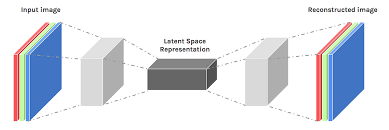

Base code source: <br> [Autoencoder In PyTorch - Theory & Implementation by Patrick Loeber](https://www.youtube.com/watch?v=zp8clK9yCro)
***

__Two basic types of autencoders use either linear layers or convolutional layers__

_Convolutional approach pefroms bettern, most likely due to access to localized feature, which are more meaningful._
***

### import libraries

In [1]:
import torch, matplotlib.pyplot as plt, numpy as np, pickle
from torchvision import (datasets, transforms)
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from torchinfo import summary
import torchvision.utils as vutils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### set working dir to repo root

In [2]:
import os
# set working dir to repo directory
head, tail = os.path.split(os.getcwd())
while tail != 'aj_python_tool_lib':
    head, tail = os.path.split(head)
os.chdir(os.path.join(head, tail))
#os.getcwd()

In [4]:
from neural_networks.nn_helper_functions import (conv2D_dims,conv2DT_dims)

### import dataset

In [5]:
data_path   = os.path.join('neural_networks', 'data')
mnist_data  = datasets.MNIST(root=data_path, train = False, transform = transforms.ToTensor())
batch_size = 32
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

img_shape = torch.tensor(mnist_data[0][0].shape)
img_n_pix = mnist_data[0][0].numel()
print(img_shape,img_n_pix)
#next(iter(data_loader))


tensor([ 1, 28, 28]) 784


# Define Linear/Convolutional network classes:
***
***
### Linear autoencoder:

In [18]:
l_layer_1 = 128
l_layer_2 = 64
l_layer_3 = 12
l_layer_4 = 3

class Autoencoder_Linear(nn.Module):
    def __init__(self):

        super(Autoencoder_Linear, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(img_n_pix, l_layer_1),
            nn.ReLU(),
            nn.Linear(l_layer_1, l_layer_2),
            nn.ReLU(),
            nn.Linear(l_layer_2, l_layer_3),
            nn.ReLU(),
            nn.Linear(l_layer_3, l_layer_4)
        )

        self.decoder = nn.Sequential(
            nn.Linear(l_layer_4, l_layer_3),
            nn.ReLU(),
            nn.Linear(l_layer_3, l_layer_2),
            nn.ReLU(),
            nn.Linear(l_layer_2, l_layer_1),
            nn.ReLU(),
            nn.Linear(l_layer_1, img_n_pix),
            nn.Sigmoid()
        )
        
    def forward(self,img):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        return decoded

model_lin = Autoencoder_Linear()
summary(model_lin, input_size=(img_n_pix,))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_Linear                       [784]                     --
├─Sequential: 1-1                        [3]                       --
│    └─Linear: 2-1                       [128]                     100,480
│    └─ReLU: 2-2                         [128]                     --
│    └─Linear: 2-3                       [64]                      8,256
│    └─ReLU: 2-4                         [64]                      --
│    └─Linear: 2-5                       [12]                      780
│    └─ReLU: 2-6                         [12]                      --
│    └─Linear: 2-7                       [3]                       39
├─Sequential: 1-2                        [784]                     --
│    └─Linear: 2-8                       [12]                      48
│    └─ReLU: 2-9                         [12]                      --
│    └─Linear: 2-10                      [64]                      832
│    

### Train Linear layer autoencoder

In [19]:
num_epochs = 15
output = []
model_lin = model_lin.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model_lin.parameters(), lr = 1e-3, weight_decay=1e-5)
OG = None
for i in range(num_epochs):
    for img_b,_ in data_loader:
        img_b_og    = img_b.clone()
        img_b       = img_b.view(-1,img_n_pix).to(device)
        reconstruct = model_lin(img_b)
        loss        = criterion(reconstruct, img_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        reconstruct_img_b = reconstruct.view(-1,*img_shape).detach().to("cpu")
        grid = vutils.make_grid(reconstruct_img_b,nrow=4, normalize=True, pad_value=1)
    output.append(np.transpose(grid,(1,2,0)))
    print('[%d\t/%d]Loss: %.4f'% (i, num_epochs, loss))#, end='\r')
    grid_og = vutils.make_grid(img_b_og,nrow=4, normalize=True, pad_value=1).detach().to("cpu")
    OG = np.transpose(grid_og,(1,2,0))
#plt.imshow(output[-1])

[0	/15]Loss: 0.0648
[1	/15]Loss: 0.0545
[2	/15]Loss: 0.0456
[3	/15]Loss: 0.0439
[4	/15]Loss: 0.0427
[5	/15]Loss: 0.0459
[6	/15]Loss: 0.0465
[7	/15]Loss: 0.0423
[8	/15]Loss: 0.0381
[9	/15]Loss: 0.0337
[10	/15]Loss: 0.0380
[11	/15]Loss: 0.0382
[12	/15]Loss: 0.0381
[13	/15]Loss: 0.0420
[14	/15]Loss: 0.0383


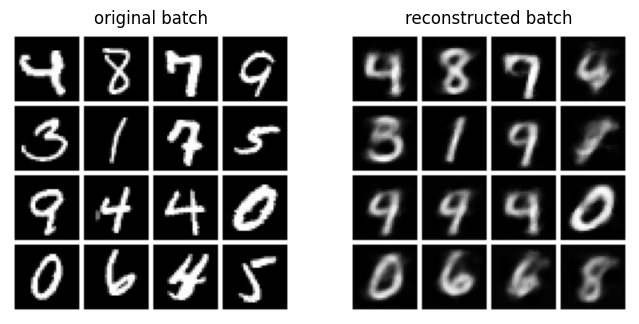

In [20]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(OG)
ax[0].set_title('original batch')
ax[1].imshow(output[-1])
ax[1].set_title('reconstructed batch')
ax[0].axis('off') 
ax[1].axis('off');

***
***
### Convolutional autoencoder


#### Generate Direct Convolution parameters:

In [6]:
conv_layer_params = torch.tensor([ #[ks , st, pd, pd_out,dil]
                                    [3  , 2 , 1 , -1    , -1],
                                    [3  , 2 , 1 , -1    , -1],
                                    [7  , 1 , 0 , -1    , -1]
])
param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']

conv_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_layer_params]

in_dims = img_shape.clone()[-2:]
for i,dic in enumerate(conv_layer_params_d):
    
    out_dims = conv2D_dims(in_dims,**dic)
    print(f'layer {i+1}; {dic}\nin_dims -> out_dims:', in_dims, ' -> ', out_dims,'\n')
    in_dims = out_dims

layer 1; {'kernel_size': 3, 'stride': 2, 'padding': 1}
in_dims -> out_dims: tensor([28, 28])  ->  tensor([14, 14]) 

layer 2; {'kernel_size': 3, 'stride': 2, 'padding': 1}
in_dims -> out_dims: tensor([14, 14])  ->  tensor([7, 7]) 

layer 3; {'kernel_size': 7, 'stride': 1, 'padding': 0}
in_dims -> out_dims: tensor([7, 7])  ->  tensor([1, 1]) 



#### Generate Transposed Convolution parameters:

In [7]:
conv_T_layer_params = torch.tensor([   #[ks , st, pd    , pd_out, dil]
                                        [7  , 2 , -1    , -1    , -1 ],
                                        [3  , 2 , 1     ,  1    , -1 ],
                                        [3  , 2 , 1     ,  1    , -1 ]
                                    ])

param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']
conv_T_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_T_layer_params]

in_dims = torch.tensor([1,1])
for i,dic in enumerate(conv_T_layer_params_d):
    out_dims = conv2DT_dims(in_dims,**dic)
    print(f'layer {i+1}; {dic}\nin_dims -> out_dims:', in_dims, ' -> ', out_dims,'\n')
    in_dims = out_dims

layer 1; {'kernel_size': 7, 'stride': 2}
in_dims -> out_dims: tensor([1, 1])  ->  tensor([7, 7]) 

layer 2; {'kernel_size': 3, 'stride': 2, 'padding': 1, 'output_padding': 1}
in_dims -> out_dims: tensor([7, 7])  ->  tensor([14, 14]) 

layer 3; {'kernel_size': 3, 'stride': 2, 'padding': 1, 'output_padding': 1}
in_dims -> out_dims: tensor([14, 14])  ->  tensor([28, 28]) 



#### Apply parameters to encoder and decoder networks

In [8]:
cc_in = 1
cc_l1 = 16
cc_l2 = 32
cc_l3 = 64

class Autoencoder_Conv(nn.Module):
    def __init__(self):

        super(Autoencoder_Conv, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(cc_in, cc_l1  , **conv_layer_params_d[0]),
            nn.ReLU(),
            nn.Conv2d(cc_l1, cc_l2  , **conv_layer_params_d[1]),
            nn.ReLU(),
            nn.Conv2d(cc_l2, cc_l3  , **conv_layer_params_d[2]),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(cc_l3, cc_l2 , **conv_T_layer_params_d[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(cc_l2, cc_l1 , **conv_T_layer_params_d[1]),
            nn.ReLU(),
            nn.ConvTranspose2d(cc_l1, cc_in , **conv_T_layer_params_d[2]),
            nn.Sigmoid()
        )
        
    def forward(self,img):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        return decoded
    
print(img_shape.numpy())
model_conv = Autoencoder_Conv()
summary(model_conv, input_size=tuple(img_shape))

[ 1 28 28]


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_Conv                         [1, 28, 28]               --
├─Sequential: 1-1                        [64, 1, 1]                --
│    └─Conv2d: 2-1                       [16, 14, 14]              160
│    └─ReLU: 2-2                         [16, 14, 14]              --
│    └─Conv2d: 2-3                       [32, 7, 7]                4,640
│    └─ReLU: 2-4                         [32, 7, 7]                --
│    └─Conv2d: 2-5                       [64, 1, 1]                100,416
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-6              [32, 7, 7]                100,384
│    └─ReLU: 2-7                         [32, 7, 7]                --
│    └─ConvTranspose2d: 2-8              [16, 14, 14]              4,624
│    └─ReLU: 2-9                         [16, 14, 14]              --
│    └─ConvTranspose2d: 2-10             [1, 28, 28]               1

### Train convolutional layer autoencoder

In [30]:
num_epochs = 15
output = []
OG = None
model_lin = model_conv.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model_conv.parameters(), lr = 1e-3, weight_decay=1e-5)
for i in range(num_epochs):
    for img_b,_ in data_loader:
        img_b = img_b.to(device)
        reconstruct = model_conv(img_b)
        loss        = criterion(reconstruct, img_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        reconstruct_img_b = reconstruct.detach().to("cpu")
        grid = vutils.make_grid(reconstruct_img_b,nrow=4, normalize=True, pad_value=1)
    output.append(np.transpose(grid,(1,2,0)))
    OG = np.transpose(vutils.make_grid(img_b,nrow=4, normalize=True, pad_value=1).detach().to("cpu"),(1,2,0))
    print('[%d\t/%d]Loss: %.4f'% (i, num_epochs, loss))#, end='\r')

[0	/15]Loss: 0.0053
[1	/15]Loss: 0.0051
[2	/15]Loss: 0.0057
[3	/15]Loss: 0.0044
[4	/15]Loss: 0.0045
[5	/15]Loss: 0.0046
[6	/15]Loss: 0.0040
[7	/15]Loss: 0.0033
[8	/15]Loss: 0.0049
[9	/15]Loss: 0.0036
[10	/15]Loss: 0.0035
[11	/15]Loss: 0.0035
[12	/15]Loss: 0.0034
[13	/15]Loss: 0.0034
[14	/15]Loss: 0.0033


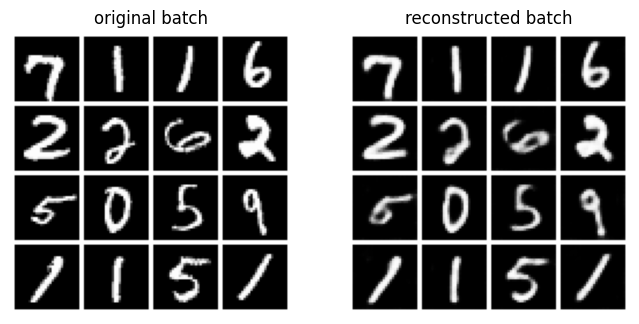

In [27]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(OG)
ax[0].set_title('original batch')
ax[1].imshow(output[-1])
ax[1].set_title('reconstructed batch')
ax[0].axis('off') 
ax[1].axis('off');